In [1]:
import os
import sys
import multiprocessing as mp
import pickle
from pathlib import Path
import wandb
import torch
import geopandas as gpd
import pandas as pd
import matplotlib.pyplot as plt
from segmentation_models_pytorch import Unet
from collections import OrderedDict
from torch.utils.data import DataLoader
from lightning.pytorch import Trainer
from sklearn.metrics import roc_auc_score, roc_curve, auc

sys.path.append("../scripts/")
from asm_datamodules import *
from asm_models import *

# Set up inference with lightning trainer functionalities

In [2]:
#artifact_dir = "/n/home07/kayan/asm/notebooks/artifacts/model-z1woyme2:v19"
artifact_dir = "/n/home07/kayan/asm/notebooks/artifacts/model-ztyg139f:v19"
state_dict = torch.load(f"{artifact_dir}/model.ckpt")["state_dict"]

In [3]:
root = "/n/holyscratch01/tambe_lab/kayan/karena/"

In [4]:
# model parameters
lr = 1e-5
n_epoch = 5
batch_size = 64
loss = "ce"
class_weights = [0.2,0.8]
num_workers = 8
mines_only = False
split = False
split_n = None
split_path = "/n/home07/kayan/asm/data/splits/9_all_data_lowlr_save-split"
freeze_backbone = False
save_split = False

task = CustomSemanticSegmentationTask(
    model="unet",
    backbone="resnet18",
    weights=True,
    loss=loss,
    class_weights = torch.Tensor(class_weights),
    in_channels=4,
    num_classes=2,
    lr=lr,
    patience=5,
    freeze_backbone=freeze_backbone,
    freeze_decoder=False
)

task.load_state_dict(state_dict)

<All keys matched successfully>

In [5]:
# device configuration
device, num_devices = ("cuda", torch.cuda.device_count()) if torch.cuda.is_available() else ("cpu", mp.cpu_count())
workers = mp.cpu_count()
torch.set_num_threads(32)

In [6]:
datamodule = ASMDataModule(batch_size=batch_size, num_workers=num_workers, split=split, split_n=split_n, 
                           root=root, transforms=min_max_transform, mines_only=mines_only, split_path=split_path)

In [68]:
trainer = Trainer(
        accelerator=device,
        devices=num_devices,
        max_epochs=n_epoch,
        logger=False,
        enable_checkpointing=False
    )

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


In [69]:
# print batchnorm running mean right after loading model
for m in task.modules():
    if isinstance(m, torch.nn.BatchNorm2d):
        print(m.running_mean)
        break

tensor([ 2.5290e-04, -7.8022e-04,  8.4609e-09, -2.9015e-03,  6.3511e-10,
         1.5038e-04,  1.6439e-03, -4.1846e-09, -1.4931e-04,  8.4100e-09,
         1.1424e-03,  1.0082e-03, -1.3288e-03, -5.9446e-08,  2.9247e-04,
         2.4724e-04,  3.5641e-03,  3.6739e-03,  1.1228e-03, -2.4790e-03,
        -1.1497e-03,  2.4511e-03, -1.3449e-03, -2.0426e-04,  1.3394e-06,
         7.9932e-04,  7.2262e-05, -4.7568e-03,  5.5096e-03, -1.2623e-03,
         2.6509e-04,  9.3015e-04, -1.7969e-03, -2.3854e-03,  3.9155e-03,
        -1.8768e-04, -2.1339e-09,  1.6510e-03, -2.0293e-10,  1.6880e-04,
        -5.2866e-05,  5.2391e-04, -9.1584e-04,  8.1977e-04,  8.3680e-04,
        -5.3720e-03,  1.3429e-03,  9.2613e-04,  8.5270e-10, -4.8065e-04,
        -1.0686e-04, -1.5154e-03,  1.2794e-04,  5.3527e-04, -1.4501e-03,
        -4.7384e-04, -4.5829e-04,  1.3580e-03, -2.2317e-03, -1.4808e-04,
        -1.2390e-03,  4.0439e-03, -1.5904e-03, -2.8378e-04], device='cuda:0')


In [70]:
trainer.test(model=task, datamodule=datamodule)

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [MIG-82e96326-37f6-5362-b068-99d475b9c87d]


Testing: |          | 0/? [00:00<?, ?it/s]

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃         Test metric         ┃        DataLoader 0         ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│   test_MulticlassAccuracy   │      0.990871012210846      │
│ test_MulticlassJaccardIndex │     0.9819071888923645      │
│          test_loss          │     0.10330305248498917     │
└─────────────────────────────┴─────────────────────────────┘

[{'test_loss': 0.10330305248498917,
  'test_MulticlassAccuracy': 0.990871012210846,
  'test_MulticlassJaccardIndex': 0.9819071888923645}]

In [71]:
# print batchnorm running mean after running task.test()
for m in task.modules():
    if isinstance(m, torch.nn.BatchNorm2d):
        print(m.running_mean)
        break

tensor([ 2.5290e-04, -7.8022e-04,  8.4609e-09, -2.9015e-03,  6.3511e-10,
         1.5038e-04,  1.6439e-03, -4.1846e-09, -1.4931e-04,  8.4100e-09,
         1.1424e-03,  1.0082e-03, -1.3288e-03, -5.9446e-08,  2.9247e-04,
         2.4724e-04,  3.5641e-03,  3.6739e-03,  1.1228e-03, -2.4790e-03,
        -1.1497e-03,  2.4511e-03, -1.3449e-03, -2.0426e-04,  1.3394e-06,
         7.9932e-04,  7.2262e-05, -4.7568e-03,  5.5096e-03, -1.2623e-03,
         2.6509e-04,  9.3015e-04, -1.7969e-03, -2.3854e-03,  3.9155e-03,
        -1.8768e-04, -2.1339e-09,  1.6510e-03, -2.0293e-10,  1.6880e-04,
        -5.2866e-05,  5.2391e-04, -9.1584e-04,  8.1977e-04,  8.3680e-04,
        -5.3720e-03,  1.3429e-03,  9.2613e-04,  8.5270e-10, -4.8065e-04,
        -1.0686e-04, -1.5154e-03,  1.2794e-04,  5.3527e-04, -1.4501e-03,
        -4.7384e-04, -4.5829e-04,  1.3580e-03, -2.2317e-03, -1.4808e-04,
        -1.2390e-03,  4.0439e-03, -1.5904e-03, -2.8378e-04])


In [63]:
test_dataloader = datamodule.test_dataloader()

In [21]:
test_dataset = ASMDataset(
        root = "/n/holyscratch01/tambe_lab/kayan/karena/",
        transforms = min_max_transform,
        split = "test",
        bands = ["R", "G", "B", "NIR"],
        split_path = split_path)
test_dataloader = DataLoader(test_dataset, batch_size=64, num_workers=8, shuffle=False)

In [27]:
test_dataloader = datamodule._dataloader_factory("test")

In [72]:
test_dataloader = trainer.test_dataloaders

In [73]:
trainer.test(model=task, dataloaders=test_dataloader)

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [MIG-82e96326-37f6-5362-b068-99d475b9c87d]


Testing: |          | 0/? [00:00<?, ?it/s]

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃         Test metric         ┃        DataLoader 0         ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│   test_MulticlassAccuracy   │     0.16873769462108612     │
│ test_MulticlassJaccardIndex │     0.09214282780885696     │
│          test_loss          │      22.92302703857422      │
└─────────────────────────────┴─────────────────────────────┘

[{'test_loss': 22.92302703857422,
  'test_MulticlassAccuracy': 0.16873769462108612,
  'test_MulticlassJaccardIndex': 0.09214282780885696}]

# Function to convert segmentation mask to image classification

In [50]:
def pixelwise_to_class(pixelwise_preds):
    class_proba = {}
    for (unique_id,preds) in pixelwise_preds.items():
        # average probability in pixels classified as mine (>0.5)
        class_proba[unique_id] = np.mean(preds*(preds>0.5))
        #class_proba[unique_id] = np.sum((preds>0.5))
    return class_proba

# Perform inference with Pytorch Lightning

In [51]:
task.training

True

In [52]:
predictions = trainer.predict(task, test_dataloader)

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [MIG-cec5870d-aaf0-5243-b78e-4f8517b75812]


Predicting: |          | 0/? [00:00<?, ?it/s]

In [53]:
task.training

False

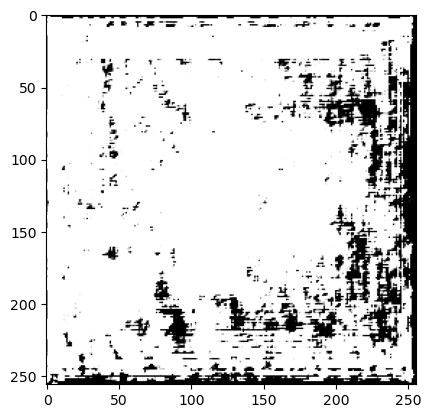

In [54]:
plt.imshow(predictions[0][0][1], cmap="gray")

In [55]:
predictions = trainer.test(task, datamodule)

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [MIG-cec5870d-aaf0-5243-b78e-4f8517b75812]


Testing: |          | 0/? [00:00<?, ?it/s]

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃         Test metric         ┃        DataLoader 0         ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│   test_MulticlassAccuracy   │      0.990871012210846      │
│ test_MulticlassJaccardIndex │     0.9819071888923645      │
│          test_loss          │     0.10330305248498917     │
└─────────────────────────────┴─────────────────────────────┘

In [56]:
predictions = trainer.test(task, dataloaders=test_dataloader)

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [MIG-cec5870d-aaf0-5243-b78e-4f8517b75812]


Testing: |          | 0/? [00:00<?, ?it/s]

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃         Test metric         ┃        DataLoader 0         ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│   test_MulticlassAccuracy   │     0.16873769462108612     │
│ test_MulticlassJaccardIndex │     0.09214282780885696     │
│          test_loss          │      22.92302894592285      │
└─────────────────────────────┴─────────────────────────────┘

In [69]:
task.train();

In [70]:
for batch in test_dataloader:
    test_image = batch["image"]
    break

In [71]:
output = task(test_image)

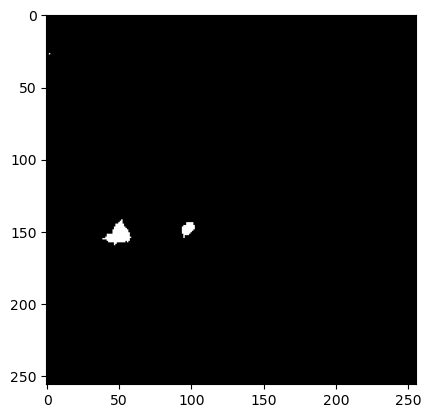

In [72]:
plt.imshow(np.argmax(output[1].detach().numpy(),axis=0), cmap="gray")

# Perform inference in eval mode

In [21]:
pixelwise_predictions = {}

task.eval()
with torch.inference_mode():
    for idx,samples in enumerate(test_dataloader):
        unique_ids = samples['id']
        # Move input data to the device
        inputs = samples['image']

        # Forward pass
        outputs = task(inputs)
        outputs = torch.softmax(outputs, dim=1)
        #outputs = outputs.argmax(dim=1).squeeze()
        
        for unique_id,output in zip(unique_ids, outputs):
            pixelwise_predictions[unique_id] = output[1].cpu().numpy()
        print(f"Batch {idx}")

Batch 0
Batch 1
Batch 2
Batch 3
Batch 4
Batch 5
Batch 6
Batch 7
Batch 8
Batch 9
Batch 10
Batch 11
Batch 12
Batch 13
Batch 14
Batch 15
Batch 16
Batch 17
Batch 18
Batch 19
Batch 20
Batch 21
Batch 22
Batch 23
Batch 24
Batch 25
Batch 26
Batch 27
Batch 28
Batch 29
Batch 30
Batch 31
Batch 32
Batch 33
Batch 34
Batch 35
Batch 36
Batch 37
Batch 38
Batch 39
Batch 40
Batch 41
Batch 42
Batch 43


In [24]:
class_proba = pixelwise_to_class(pixelwise_predictions)

In [25]:
path="/n/home07/kayan/asm/data/filtered_labels.geojson"
label_df = gpd.read_file(path)

true_labels = [label_df[label_df["unique_id"]==x]["label"].values[0] for x in class_proba.keys()]

In [26]:
class_proba = list(class_proba.values())

Text(0, 0.5, 'True Positive')

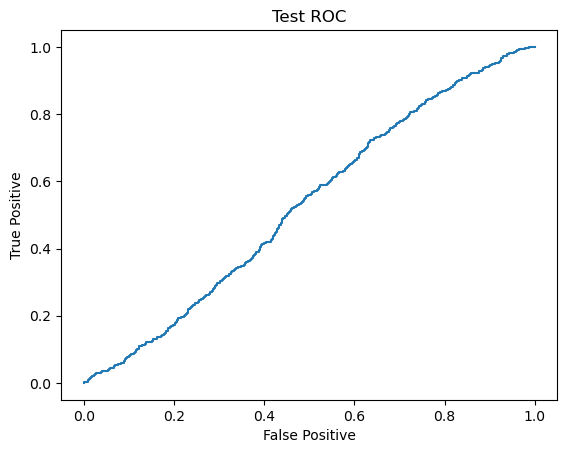

In [27]:
fig,ax = plt.subplots()
fpr, tpr, _ = roc_curve(true_labels, class_proba)
ax.plot(fpr, tpr)
ax.set_title("Test ROC")
ax.set_xlabel("False Positive")
ax.set_ylabel("True Positive")

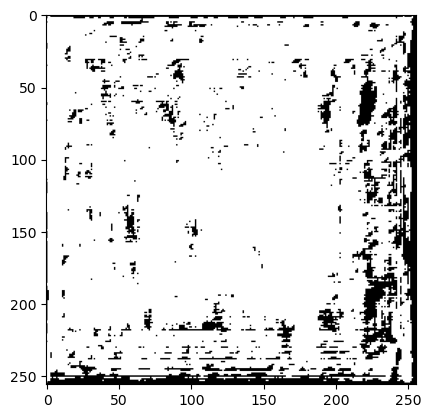

In [28]:
plt.imshow(pixelwise_predictions['lat_8--655__lon_-11--055']>0.5,cmap="gray")

In [29]:
# print batchnorm running mean after running prediction with task.eval()
for m in task.modules():
    if isinstance(m, torch.nn.BatchNorm2d):
        print(m.running_mean)
        break

tensor([ 2.5290e-04, -7.8022e-04,  8.4609e-09, -2.9015e-03,  6.3511e-10,
         1.5038e-04,  1.6439e-03, -4.1846e-09, -1.4931e-04,  8.4100e-09,
         1.1424e-03,  1.0082e-03, -1.3288e-03, -5.9446e-08,  2.9247e-04,
         2.4724e-04,  3.5641e-03,  3.6739e-03,  1.1228e-03, -2.4790e-03,
        -1.1497e-03,  2.4511e-03, -1.3449e-03, -2.0426e-04,  1.3394e-06,
         7.9932e-04,  7.2262e-05, -4.7568e-03,  5.5096e-03, -1.2623e-03,
         2.6509e-04,  9.3015e-04, -1.7969e-03, -2.3854e-03,  3.9155e-03,
        -1.8768e-04, -2.1339e-09,  1.6510e-03, -2.0293e-10,  1.6880e-04,
        -5.2866e-05,  5.2391e-04, -9.1584e-04,  8.1977e-04,  8.3680e-04,
        -5.3720e-03,  1.3429e-03,  9.2613e-04,  8.5270e-10, -4.8065e-04,
        -1.0686e-04, -1.5154e-03,  1.2794e-04,  5.3527e-04, -1.4501e-03,
        -4.7384e-04, -4.5829e-04,  1.3580e-03, -2.2317e-03, -1.4808e-04,
        -1.2390e-03,  4.0439e-03, -1.5904e-03, -2.8378e-04])


# Perform inference in train mode

In [30]:
pixelwise_predictions = {}

task.train()
with torch.inference_mode():
    for idx,samples in enumerate(test_dataloader):
        unique_ids = samples['id']
        # Move input data to the device
        inputs = samples['image']

        # Forward pass
        outputs = task(inputs)
        outputs = torch.softmax(outputs, dim=1)
        #outputs = outputs.argmax(dim=1).squeeze()
        
        for unique_id,output in zip(unique_ids, outputs):
            pixelwise_predictions[unique_id] = output[1].cpu().numpy()
        print(f"Batch {idx}")

/n/home07/kayan/miniconda3/envs/geo-ml/lib/python3.11/site-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 1, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


Batch 0
Batch 1
Batch 2
Batch 3
Batch 4
Batch 5
Batch 6
Batch 7
Batch 8
Batch 9
Batch 10
Batch 11
Batch 12
Batch 13
Batch 14
Batch 15
Batch 16
Batch 17
Batch 18
Batch 19
Batch 20
Batch 21
Batch 22
Batch 23
Batch 24
Batch 25
Batch 26
Batch 27
Batch 28
Batch 29
Batch 30
Batch 31
Batch 32
Batch 33
Batch 34
Batch 35
Batch 36
Batch 37
Batch 38
Batch 39
Batch 40
Batch 41
Batch 42
Batch 43


In [31]:
class_proba = pixelwise_to_class(pixelwise_predictions)

In [32]:
path="/n/home07/kayan/asm/data/filtered_labels.geojson"
label_df = gpd.read_file(path)

true_labels = [label_df[label_df["unique_id"]==x]["label"].values[0] for x in class_proba.keys()]

In [33]:
class_proba = list(class_proba.values())

Text(0, 0.5, 'True Positive')

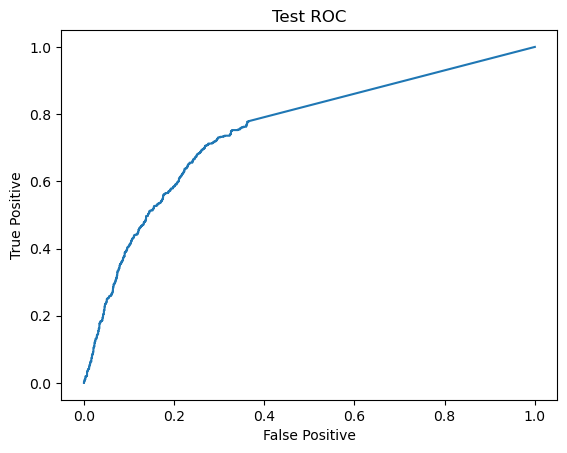

In [34]:
fig,ax = plt.subplots()
fpr, tpr, _ = roc_curve(true_labels, class_proba)
ax.plot(fpr, tpr)
ax.set_title("Test ROC")
ax.set_xlabel("False Positive")
ax.set_ylabel("True Positive")

In [35]:
# print batchnorm running mean after running forward passes with task.train()
for m in task.modules():
    if isinstance(m, torch.nn.BatchNorm2d):
        print(m.running_mean)
        break

tensor([ 6.2983e-02, -1.9308e-01,  2.1087e-06, -7.2371e-01,  1.5815e-07,
         3.7871e-02,  4.1872e-01, -1.0442e-06, -3.7178e-02,  2.0390e-06,
         2.8489e-01,  2.5062e-01, -3.2965e-01, -1.4614e-05,  7.2261e-02,
         6.2205e-02,  8.9477e-01,  9.1739e-01,  2.7819e-01, -6.1500e-01,
        -2.8624e-01,  6.0756e-01, -3.3339e-01, -5.0843e-02, -2.9300e-04,
         1.9709e-01,  1.8360e-02, -1.1965e+00,  1.3848e+00, -3.1380e-01,
         6.6774e-02,  2.3159e-01, -4.5091e-01, -6.0640e-01,  9.7794e-01,
        -4.2869e-02, -5.3265e-07,  4.1266e-01, -5.0081e-08,  4.1560e-02,
        -1.3971e-02,  1.2988e-01, -2.2773e-01,  2.0466e-01,  2.0750e-01,
        -1.3461e+00,  3.3220e-01,  2.3041e-01,  2.1287e-07, -1.1991e-01,
        -2.7059e-02, -3.7767e-01,  2.5444e-02,  1.3287e-01, -3.6064e-01,
        -1.1812e-01, -1.1457e-01,  3.3873e-01, -5.5369e-01, -3.7366e-02,
        -3.0778e-01,  1.0052e+00, -3.9464e-01, -7.0303e-02])


# Perform inference in eval mode with TRAIN dataset

In [92]:
# model parameters
lr = 1e-5
n_epoch = 5
batch_size = 64
loss = "ce"
class_weights = [0.2,0.8]
num_workers = 8
mines_only = False
split = False
split_n = None
split_path = "/n/home07/kayan/asm/data/splits/9_all_data_lowlr_save-split"
freeze_backbone = False
save_split = False

task = CustomSemanticSegmentationTask(
    model="unet",
    backbone="resnet18",
    weights=True,
    loss=loss,
    class_weights = torch.Tensor(class_weights),
    in_channels=4,
    num_classes=2,
    lr=lr,
    patience=5,
    freeze_backbone=freeze_backbone,
    freeze_decoder=False
)

task.load_state_dict(state_dict)

<All keys matched successfully>

In [93]:
train_dataset = ASMDataset(
        root = "/n/holyscratch01/tambe_lab/kayan/karena/",
        transforms = min_max_transform,
        split = "train",
        bands = ["R", "G", "B", "NIR"],
        split_path = split_path)
train_dataloader = DataLoader(train_dataset, batch_size=64, num_workers=32, shuffle=True)

/n/home07/kayan/miniconda3/envs/geo-ml/lib/python3.11/site-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 32 worker processes in total. Our suggested max number of worker in current system is 1, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


In [94]:
# device configuration
device, num_devices = ("cuda", torch.cuda.device_count()) if torch.cuda.is_available() else ("cpu", mp.cpu_count())
workers = mp.cpu_count()
torch.set_num_threads(32)

In [95]:
trainer = Trainer(
        accelerator=device,
        devices=num_devices,
        max_epochs=n_epoch,
        logger=False,
        enable_checkpointing=False
    )

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


In [96]:
# print batchnorm running mean after loading model
for m in task.modules():
    if isinstance(m, torch.nn.BatchNorm2d):
        print(m.running_mean)
        break

tensor([ 2.5290e-04, -7.8022e-04,  8.4609e-09, -2.9015e-03,  6.3511e-10,
         1.5038e-04,  1.6439e-03, -4.1846e-09, -1.4931e-04,  8.4100e-09,
         1.1424e-03,  1.0082e-03, -1.3288e-03, -5.9446e-08,  2.9247e-04,
         2.4724e-04,  3.5641e-03,  3.6739e-03,  1.1228e-03, -2.4790e-03,
        -1.1497e-03,  2.4511e-03, -1.3449e-03, -2.0426e-04,  1.3394e-06,
         7.9932e-04,  7.2262e-05, -4.7568e-03,  5.5096e-03, -1.2623e-03,
         2.6509e-04,  9.3015e-04, -1.7969e-03, -2.3854e-03,  3.9155e-03,
        -1.8768e-04, -2.1339e-09,  1.6510e-03, -2.0293e-10,  1.6880e-04,
        -5.2866e-05,  5.2391e-04, -9.1584e-04,  8.1977e-04,  8.3680e-04,
        -5.3720e-03,  1.3429e-03,  9.2613e-04,  8.5270e-10, -4.8065e-04,
        -1.0686e-04, -1.5154e-03,  1.2794e-04,  5.3527e-04, -1.4501e-03,
        -4.7384e-04, -4.5829e-04,  1.3580e-03, -2.2317e-03, -1.4808e-04,
        -1.2390e-03,  4.0439e-03, -1.5904e-03, -2.8378e-04])


In [ ]:
pixelwise_predictions = {}

task.eval()
with torch.inference_mode():
    for idx,samples in enumerate(train_dataloader):
        unique_ids = samples['id']
        # Move input data to the device
        inputs = samples['image']

        # Forward pass
        outputs = task(inputs)
        outputs = torch.softmax(outputs, dim=1)
        #outputs = outputs.argmax(dim=1).squeeze()
        
        for unique_id,output in zip(unique_ids, outputs):
            pixelwise_predictions[unique_id] = output[1].cpu().numpy()
        print(f"Batch {idx}")

In [45]:
class_proba = pixelwise_to_class(pixelwise_predictions)

In [46]:
path="/n/home07/kayan/asm/data/filtered_labels.geojson"
label_df = gpd.read_file(path)

true_labels = [label_df[label_df["unique_id"]==x]["label"].values[0] for x in class_proba.keys()]

In [47]:
class_proba = list(class_proba.values())

Text(0, 0.5, 'True Positive')

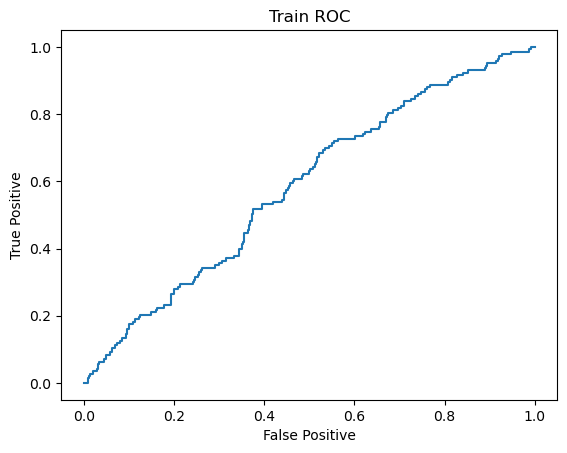

In [49]:
fig,ax = plt.subplots()
fpr, tpr, _ = roc_curve(true_labels, class_proba)
ax.plot(fpr, tpr)
ax.set_title("Train ROC")
ax.set_xlabel("False Positive")
ax.set_ylabel("True Positive")

# Perform inference in train mode with TRAIN dataset

In [ ]:
pixelwise_predictions = {}

task.train()
with torch.inference_mode():
    for idx,samples in enumerate(train_dataloader):
        unique_ids = samples['id']
        # Move input data to the device
        inputs = samples['image']

        # Forward pass
        outputs = task(inputs)
        outputs = torch.softmax(outputs, dim=1)
        #outputs = outputs.argmax(dim=1).squeeze()
        
        for unique_id,output in zip(unique_ids, outputs):
            pixelwise_predictions[unique_id] = output[1].cpu().numpy()
        print(f"Batch {idx}")

In [99]:
# print batchnorm running mean after running forward passes on train dataset
for m in task.modules():
    if isinstance(m, torch.nn.BatchNorm2d):
        print(m.running_mean)
        break

tensor([ 6.3632e-02, -1.9681e-01,  2.1479e-06, -7.3180e-01,  1.5986e-07,
         3.8347e-02,  4.1996e-01, -1.0568e-06, -3.8101e-02,  2.2509e-06,
         2.9007e-01,  2.5476e-01, -3.3800e-01, -1.5680e-05,  7.3380e-02,
         6.3387e-02,  8.9976e-01,  9.2576e-01,  2.8657e-01, -6.2614e-01,
        -2.9053e-01,  6.1925e-01, -3.4120e-01, -5.2307e-02, -1.1478e-04,
         2.0179e-01,  1.8541e-02, -1.1941e+00,  1.3814e+00, -3.1940e-01,
         6.7807e-02,  2.3510e-01, -4.4545e-01, -6.0335e-01,  9.8568e-01,
        -5.3417e-02, -5.3817e-07,  4.1906e-01, -5.1717e-08,  4.2233e-02,
        -1.3563e-02,  1.3251e-01, -2.3145e-01,  2.0838e-01,  2.1157e-01,
        -1.3517e+00,  3.3909e-01,  2.3425e-01,  2.1562e-07, -1.2183e-01,
        -2.7333e-02, -3.8423e-01,  2.3896e-02,  1.3539e-01, -3.6987e-01,
        -1.2064e-01, -1.1615e-01,  3.4483e-01, -5.6268e-01, -3.7383e-02,
        -3.1329e-01,  1.0226e+00, -4.0527e-01, -7.1274e-02])


In [100]:
class_proba = pixelwise_to_class(pixelwise_predictions)

In [101]:
path="/n/home07/kayan/asm/data/filtered_labels.geojson"
label_df = gpd.read_file(path)

true_labels = [label_df[label_df["unique_id"]==x]["label"].values[0] for x in class_proba.keys()]

In [102]:
class_proba = list(class_proba.values())

Text(0, 0.5, 'True Positive')

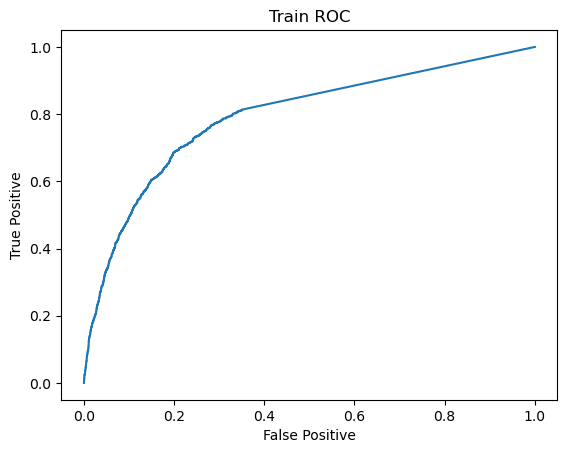

In [103]:
fig,ax = plt.subplots()
fpr, tpr, _ = roc_curve(true_labels, class_proba)
ax.plot(fpr, tpr)
ax.set_title("Train ROC")
ax.set_xlabel("False Positive")
ax.set_ylabel("True Positive")

In [104]:
predictions = trainer.test(task, dataloaders=test_dataloader)

/n/home07/kayan/miniconda3/envs/geo-ml/lib/python3.11/site-packages/lightning/fabric/plugins/environments/slurm.py:191: The `srun` command is available on your system but is not used. HINT: If your intention is to run Lightning on SLURM, prepend your python command with `srun` like so: srun python /n/home07/kayan/miniconda3/envs/geo-ml/lib/python3.1 ...
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [MIG-cec5870d-aaf0-5243-b78e-4f8517b75812]
/n/home07/kayan/miniconda3/envs/geo-ml/lib/python3.11/site-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 1, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


Testing: |          | 0/? [00:00<?, ?it/s]

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃         Test metric         ┃        DataLoader 0         ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│   test_MulticlassAccuracy   │     0.9853507876396179      │
│ test_MulticlassJaccardIndex │     0.9711247086524963      │
│          test_loss          │     0.11056164652109146     │
└─────────────────────────────┴─────────────────────────────┘